In [340]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
from tqdm import tqdm
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from urllib.request import urlopen

options = webdriver.ChromeOptions()

prefs = {'download.default_directory':'C:\VENV\selenium\data',
         'download.prompt_for_downloads':False}
options.add_experimental_option('prefs',prefs)
#트리마제 시세분석
url = "https://new.land.naver.com/complexes/108405?ms=37.539024,127.0447194,18&a=APT:ABYG:JGC:PRE&e=RETAIL"
driver = webdriver.Chrome(service=Service("../driver/chromedriver.exe"),
                          options=options)
driver.get(url)

In [347]:
info_tab = driver.find_element(By.XPATH, '''//*[@id="summaryInfo"]/div[2]/div[2]/button[2]''')
info_tab.click()



In [348]:
tab_btn = info_tab.find_element(By.XPATH, '''//*[@id="tabpanel1"]/div[6]/div/button[2]''')
tab_btn.click()

In [349]:
from selenium.webdriver import ActionChains
i = 0
action = ActionChains(driver)
more_btn = driver.find_element(By.XPATH, '''//*[@id="tabpanel1"]/div[7]/button''')
for i in range(65):
    action.move_to_element(more_btn).perform()
    more_btn.click() 
    
action.move_to_element(more_btn).perform()

In [350]:
info_list = []

In [351]:
chart = driver.find_element(By.XPATH, '''//*[@id="tabpanel1"]''')
price_table = chart.find_element(By.XPATH, '''//*[@id="tabpanel1"]/div[7]''')
prices = price_table.find_elements(By.TAG_NAME, "tr")
for price in prices:
    price_text = price.text
    info_list.append(price_text)


In [ ]:
info_list

In [676]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [363]:

info_list.pop(0)

'기준일 하위평균가 일반평균가 상위평균가 매매가 대비 전세가'

In [372]:
split_list = []
date_list = []
L_avg_list =[]
avg_list = []
U_avg_list = []
for info in(info_list):
    split_list = info.split()
    date_list.append(split_list[0])
    L_avg_list.append(split_list[1])
    avg_list.append(split_list[2])
    U_avg_list.append(split_list[3])
    
    

In [656]:
columns = ['기준일']
df_date = pd.DataFrame(date_list,columns = columns)

In [657]:
import re
columns = ['하위 평균가']
df_L_avg = pd.DataFrame(L_avg_list,columns = columns)

df_L_avg['하위 평균가'] = df_L_avg['하위 평균가'].apply(lambda x: x + ' 만' if re.search(r'억\s*\d', x) else x)
df_L_avg['하위 평균가'] = (df_L_avg['하위 평균가']).replace(' ', '', regex=True)
df_L_avg.head()


,하위 평균가
0,"9억9,000만"
1,"9억9,000만"
2,"9억9,000만"
3,"9억9,000만"
4,"9억9,000만"


In [658]:
columns = ['평균가']
df_avg = pd.DataFrame(avg_list,columns = columns)
df_avg['평균가'] = df_avg['평균가'].apply(lambda x: x + ' 만' if re.search(r'억\s*\d', x) else x)
df_avg['평균가'] = (df_avg['평균가']).replace(' ', '', regex=True)

In [ ]:
columns = ['상위 평균가']
df_U_avg = pd.DataFrame(U_avg_list,columns = columns)
df_U_avg['상위 평균가'] = df_U_avg['상위 평균가'].apply(lambda x: x + ' 만' if re.search(r'억\s*\d', x) else x)
df_U_avg['상위 평균가'] = (df_U_avg['상위 평균가']).replace(' ', '', regex=True)

df_U_avg[:65]

In [660]:
result = pd.concat([df_date, df_L_avg,df_avg, df_U_avg],axis = 1)
data = result

df_total = pd.DataFrame(data)

In [ ]:
df_total.head()

In [ ]:
df_total.info()

In [663]:
import re

def convert_string_to_number(s):
    # 문자열에서 '억'과 '만'을 찾아서 숫자로 변환
    billion = int(re.findall(r'(\d+)억', s)[0] if '억' in s else 0)
    million = int(re.findall(r'(\d+)만', s)[0] if '만' in s else 0)
    result = billion * 100000000 + million * 10000
    return result


In [ ]:
dfs = [df_date, df_L_avg, df_avg, df_U_avg]

df_total['하위 평균가'] = df_total['하위 평균가'].apply(convert_string_to_number)
df_total['평균가'] = df_total['평균가'].apply(convert_string_to_number)
df_total['상위 평균가'] = df_total['상위 평균가'].apply(convert_string_to_number)

df_total

In [ ]:
df_total['기준일'] = pd.to_datetime(df_total['기준일'])

In [742]:
df_total['YearMonth'] = pd.to_datetime(df_total['기준일']).dt.to_period('M')

# 'YearMonth'를 기준으로 그룹화하고 각 그룹에 대해 평균 계산
result_df = df_total.groupby('YearMonth').agg({
    '하위 평균가': 'mean',
    '평균가': 'mean',
    '상위 평균가': 'mean'
}).reset_index()

# 결과 출력
result_df.columns

Index(['YearMonth', '하위 평균가', '평균가', '상위 평균가'], dtype='object')

In [743]:
total_df = result_df.set_index('YearMonth')

In [744]:
total_df

,하위 평균가,평균가,상위 평균가
YearMonth,,,
2018-10,700000000.0,7.000000e+08,8.000000e+08
2018-11,700000000.0,7.000000e+08,8.000000e+08
2018-12,700000000.0,7.000000e+08,8.000000e+08
2019-01,700000000.0,7.000000e+08,8.000000e+08
2019-02,700000000.0,7.000000e+08,8.000000e+08
...,...,...,...
2023-09,900000000.0,1.000000e+09,1.100000e+09
2023-10,900000000.0,1.000000e+09,1.100000e+09
2023-11,900000000.0,1.000000e+09,1.100000e+09


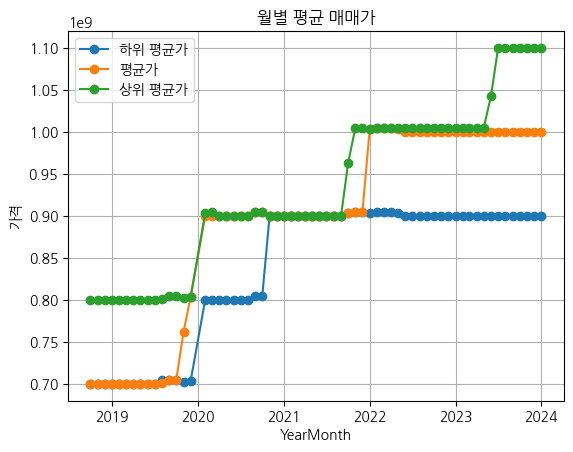

In [762]:
%matplotlib inline
# 그래프 그리기



plt.plot(total_df.index, total_df['하위 평균가'], marker='o', label='하위 평균가')
plt.plot(total_df.index, total_df['평균가'], marker='o', label='평균가')
plt.plot(total_df.index, total_df['상위 평균가'], marker='o', label='상위 평균가')

plt.grid(True)
plt.grid(True)
plt.title("월별 평균 매매가")
plt.xlabel("YearMonth")
plt.ylabel("가격")
plt.legend()
plt.show()

In [758]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 63 entries, 2018-10 to 2024-01
Freq: M
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   하위 평균가  63 non-null     float64
 1   평균가     63 non-null     float64
 2   상위 평균가  63 non-null     float64
dtypes: float64(3)
memory usage: 2.0 KB


In [764]:
import plotly.express as px
fig = px.line(total_df, total_df.index, y=['하위 평균가', '평균가', '상위 평균가'], markers=True, line_shape='linear')

# 툴팁 추가
fig.update_traces(mode='lines+markers', hovertemplate='가격: %{y:.2f}<br>날짜: %{x|%Y-%m}')

# 그래프 출력
fig.show()